# Week 4. MNIST handwritten digit classification with CNN

This time, we will implement Convolutional Neural Network(**CNN**) model for MNIST digit classification.

First, let's import libraries and load *MNIST* training data to data loaders.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

from sys import stdout

import os

cuda = torch.cuda.is_available()

In [ ]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# This will automatically download MNIST data into ./data directory
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,    
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)  

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

## 1. Convolutional Neural Network - Preliminaries
Today, we will implement a **Convolutional Neural Network(CNN)**. **CNN** uses several special operations, which differentiates it from *MLP*. Compared to *MLP*, following operations appear in **CNN**:

* Convolutions
* Pooling (Max-Pooling / Average-Pooling)

In this section, we'll see how those operations work.

### 1.1. Convolutions

Convolution is one of the most characteristic features of CNN. *PyTorch* offers several variations of convolutions in `nn.Module`. 

1. 1D Convolution [`torch.nn.Conv1d(in_channels, out_channels, kernel_size, ...)
`](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html#torch.nn.Conv1d)

2. **2D Convolution** [`torch.nn.Conv2d(in_channels, out_channels, kernel_size, ...)`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) 

3. 3D Convolution [`torch.nn.Conv3d(in_channels, out_channels, kernel_size, ...)`](https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html#torch.nn.Conv3d)

**2D Convolution** is widely used for processing **image** data. We will also use `torch.nn.Conv2d` for our implementation, since *MNIST* is an image dataset. Now let's see how it works.

In convolution, we have a fixed size arrays**(kernels)** that moves through input data. In `torch.nn.Conv2d`, several parameters are **required**. 

*   `in_channels`, `out_channels` : Specifies number of input/output channels(**Cᵢₙ, Cₒᵤₜ**).

* `kernel_size` : Specifies size of kernel (as *tuple* of *integers (non-square kernel)* or *integer (square kernel)*). 


If (input/output) channel and kernel sizes are specified, a convolution layer will change dimension of tensors. 

  $$ B × C_{in} × W_{in} × H_{in} ⟶ B × C_{out} × W_{out} × H_{out} $$



- **Cᵢₙ** and **Cₒᵤₜ** will be same as you define in `nn.Conv2d(in_channels, out_channels, ...)`. 
- **W** and **H** will differ, in accordance to `kernel_size`.

  
Let's take a look at several examples of `nn.Conv2d` for better understanding.

In [ ]:
B = 5
C_in = 1
W_in = 20
H_in = 10

C_out = 5

input_tensor = torch.randn(B, C_in, W_in, H_in)

conv1 = nn.Conv2d(C_in, C_in, 3)        # Channels are identical. Square kernel of 3x3.
conv2 = nn.Conv2d(C_in, C_in, (8, 5))   # Channels are identical. Non-square kernel of 8x5
conv3 = nn.Conv2d(C_in, C_out, (8, 5))  # Channels are different. Non-square kernel of 8x5
conv4 = nn.Conv2d(C_out, 2*C_out, 2)    # Increase channel dimension by x2.
conv5 = nn.Conv2d(2*C_out, 1, (10, 3))    # Reduce channel dimension to 1

# Input shape
print("input_tensor = ", input_tensor.shape)

# Single convolution layer with square kernel
t1 = conv1(input_tensor)
print("conv1(input_tensor) = ", t1.shape)

# Single convolution layer with non-square kernel
t2 = conv2(input_tensor)
print("conv2(input_tensor) = ", t2.shape)

# Single convolution layer, increasing output channel size, non-square kernel
t3 = conv3(input_tensor)
print("conv3(input_tensor) = ", t3.shape)

# Sequential convolutions - I
t4 = conv4(conv3(input_tensor))
print("conv4(conv3(input_tensor)) = ", t4.shape)

# Reducing channel dimensions
t5 = conv5(t4)
print("conv5(conv4(conv3(input_tensor)) = ", t5.shape)

Several advanced options are available for `torch.nn.Conv2d`. *Stride, dilation, padding* can be applied to tensors. Note that we will **NOT** use these options today, but these *might* appear in later part of the course.

* `stride` (default = 1). Instead of moving kernel by 1 step, we can skip some steps to reduce dimensions (width / height).

* `dilation` (default = 1). Setting this 2 or greater will result in **Atrous Convolution**(=**Dilated Convolution**). 

* `padding` (default = 0). Setting this 1 or greater will add a zero padding at input tensor. This is usually used to prevent output tensor size from shrinking too quickly. 

You may refer to following examples for usages.

In [ ]:
input_tensor = torch.randn(B, C_in, 11, 11)

cnn_normal = nn.Conv2d(C_in, C_out, 2)  # Rectangular kernel of size 2x2
cnn_stride = nn.Conv2d(C_in, C_out, 2, stride=2)      # Stride = 2
cnn_dilation = nn.Conv2d(C_in, C_out, 2, dilation=2)  # Dilation = 2
cnn_padding = nn.Conv2d(C_in, C_out, 2, padding=1)    # Padding = 2

t1 = cnn_normal(input_tensor)
t2 = cnn_stride(input_tensor)
t3 = cnn_dilation(input_tensor)
t4 = cnn_padding(input_tensor)

print(input_tensor.shape)
print(t1.shape)
print(t2.shape)
print(t3.shape)
print(t4.shape)

### 1.2. Pooling

In **CNN**, *pooling* operations are widely used together with convolutions. These reduce dimensions of tensors(thereby reduce computational load), as well as help to avoid overfitting.

[Average Pooling](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) and [Max Pooling](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) are two of the widely used pooling operations.

In [ ]:
maxpool = nn.MaxPool2d(2)   # Max Pooling in 2D. kernel size = 2x2
avgpool = nn.AvgPool2d(2)   # Avg Pooling in 2D. kernel size = 2x2

# Input Tensor of size 1 x 1 x 4 x 4
input_tensor = torch.tensor(np.array([[1, 2, 3, 4],
                                      [5, 6, 7, 8],
                                      [9, 10, 11, 12],
                                      [13, 14, 15, 16]], dtype=np.float32)).unsqueeze(0).unsqueeze(0)
                                  

print("MaxPool(input)\n", maxpool(input_tensor), end="\n\n")
print("AvgPool(input)\n", avgpool(input_tensor))


---
## 2. Convolutional Neural Network

Let's define our own model. This time, we are using *Convolutional Neural Network*. Since *MNIST* has 2-dimensional data, we are using `nn.Conv2d` in our network definition.

Refer to following figure for detailed implementation.

> **Task 1. Implement MyCNN class.**

- Fill in functions `__init__()` and `__forward__()` of `MyCNN` class to define an **CNN** described below.
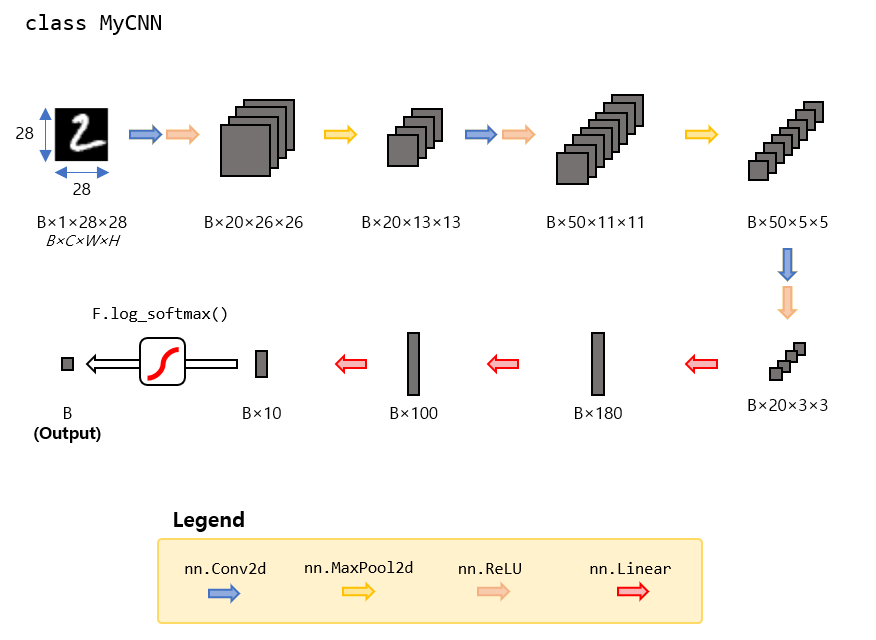

In [ ]:
# Convolutional Neural Network (CNN)
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.activation = nn.ReLU()

        # Start your implementation here
        # self.cnn1 = ...
        # self.maxpool1 = ...
        
        

    def forward(self, x):
        # x = ...
        
        return F.log_softmax(x, dim=0)

model = MyCNN()

if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

**Training / Validation**

Last time, we implemented `train()` pipeline. Today, we'll assume that you're familiar with training process in *PyTorch*. Therefore, you don't need to change anything in `train()` and `validate()`.


In [ ]:
# Training loop. Do not change.
def train(model, optimizer, epoch, log_interval=100):
    model.train()   # Set model to training mode
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Clear remaining gradients by setting to zero        
        optimizer.zero_grad()

        # Call forward() of model
        output = model(data)
        
        # Compute loss (Negative Log Likelihood)
        loss = F.nll_loss(output, target.detach())

        # Compute gradients
        loss.backward()

        # Backpropagation by updating weights
        optimizer.step()

    ## CLI Visualization (Optional) ##
        if (((batch_idx % log_interval) == 0) or (batch_idx == len(train_loader)-1)):
            prog = 100. * (batch_idx+1) / len(train_loader)
            L = int(prog/5)

            stdout.write('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\t|'.format(
                epoch, (batch_idx+1) * len(data), len(train_loader.dataset),
                prog) + ("=" * L + ">" + " " * (20-L) + "|") )
            
            stdout.flush()
    stdout.write("\n")
    ## CLI Visualization End ##

In [ ]:
# Validation Loop. Do not change.
def validate(loss_vector_CNN, accuracy_vector_CNN):
    model.eval()

    val_loss_CNN, correct_CNN = 0, 0

    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output_CNN = model(data)

        val_loss_CNN += F.nll_loss(output_CNN, target).item()
        pred_CNN = output_CNN.data.max(1)[1] # get the index of the max log-probability
        correct_CNN += pred_CNN.eq(target.data).cpu().sum()

    val_loss_CNN /= len(validation_loader)
    loss_vector_CNN.append(val_loss_CNN)

    accuracy_CNN = 100. * correct_CNN / len(validation_loader.dataset)
    accuracy_vector_CNN.append(accuracy_CNN)

    print('Validation set (CNN): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss_CNN, correct_CNN, len(validation_loader.dataset), accuracy_CNN))

**Checkpointing**

Instead, we will add an additional feature in our training pipeline. Since training takes long time, you may wish to *save weights* after training completes, so that you can *continue* later on. To **CONTINUE** training from checkpoint, we **MUST** save all information containing training status. To be specific, we must save our

  - weights of our model 
  - optimizer parameters 
  - epochs

Therefore, we will save all these information in a single python `dict()` object. A helper function `save_model(...)` which saves our trained `model`, `optimizer`, and `epoch` is defined for you.

In [ ]:
def save_model(model_, optimizer_, epoch_, save_as="best.pt"):
    best_model = {'model':model_.state_dict(),
                  'optimizer':optimizer_.state_dict(),
                  'epoch':epoch_}

    torch.save(best_model, save_as)

# Usage : save_model(model, optimizer, epoch)

**Train our `MyCNN`**

In this part, we only train our `MyCNN` model with *MNIST dataset*. Since training takes long time, we will use `epoch = 10` today. We wish to save our trained model if **recent validation loss is the lowest**.

> Task 2. Complete checkpointing

-  After each epoch, save our trained model/optimizer/epoch only if recent validation loss is minimum. Change `save_condition` to achieve this (*one-liner*).

In [ ]:
%%time
epochs = 10

lossv_CNN, accv_CNN = [], []

for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch)
    validate(lossv_CNN, accv_CNN)

    ## Task 2. Checkpointing ##
    # Save your model only if recent validation loss is minimum

    # Change this line
    save_condition = False

    if save_condition:
        save_model(model, optimizer, epoch)
        
    ##


**Visualization**

Finally, let's see if our CNN is trained properly. If you have implemented correctly, final validation accuracy will be near **96 ~ 97%**.

Same as last time, you will be asked to **SUBMIT two figures** and **best.pt** as proofs of your completion. 

Find your `best.pt` file in file browser at the left in your workspace.

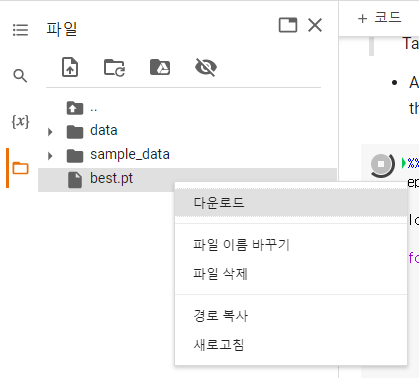

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv_CNN, label="MyCNN")
plt.legend()
plt.title('Validation Loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv_CNN, label="MyCNN")
plt.legend()
plt.title('Validation Accuracy (%)');

**Loading pre-trained weights**

  We saved our trained model and optimizer parameters in `best.pt` file. This section will show how to load pretrained weights.

In [ ]:
best_model_path = "./best.pt"

if os.path.exists(best_model_path): 
    best_model = torch.load(best_model_path)
    model.load_state_dict(best_model['model'])
    optimizer.load_state_dict(best_model['optimizer'])
    last_epoch = best_model['epoch'] + 1